## Notes
- Specify dtype using memmap. Fml.

## Imports

In [1]:
import os
import numpy as np
import madmom as mm
import librosa as lr
import pretty_midi as pm
import matplotlib.pyplot as plt

## Constants

In [2]:
DATA_DIR = "../datasets/maps/CH/"
INPUT_NAME = "./inputs.dat"
EXPECT_NAME = "./expects.dat"

## Helpers

In [28]:
def log_filt(path):
    return  mm.audio.spectrogram.LogarithmicFilteredSpectrogram(
        path,
        num_bands=36,
        num_channels=1, 
        sr=22050,
        unique_filters=True,
        norm_filters=True,
        frame_size=4096,
        fft_size=4096,
        fps=100,
        fmin=30,
        fmax=8000.0,
        fref=440.0,
        circular_shift=False,
        hop_size=512.0)

In [29]:
def save_mm(path, datapoint):
    mm_datapoint = np.memmap(
                        filename=path,
                        dtype='float32',
                        mode='w+',
                        shape=datapoint.shape)
    mm_datapoint[:] = datapoint[:]
    del mm_datapoint
    
def load_mm():
    NOTE_RANGE = 88
    N_BINS = 229

    mm_input = np.memmap(INPUT_NAME, 
                         mode='r',
                         dtype='float32'
                        )
    mm_output = np.memmap(EXPECT_NAME, 
                          mode='r',
                          dtype='float32'
                         )
    input = np.reshape(mm_input, (-1, N_BINS))
    output = np.reshape(mm_output, (-1, NOTE_RANGE))

    return input, output

## Load and Transform Samples

In [30]:
wavs = [d for d in os.listdir(DATA_DIR) if d.endswith('.wav')]

In [31]:
spects_onsets_froms = []
for w in wavs:
    wav_path = os.path.join(DATA_DIR, w)
    midi_path = os.path.join(DATA_DIR, w.replace('.wav', '.mid'))
    
    spect = lr.util.normalize(log_filt(wav_path))
    times = lr.frames_to_time(np.arange(spect.shape[0]), sr=44100, hop_length=441.0)
    midi = pm.PrettyMIDI(midi_path)
    froms = midi.get_piano_roll(fs=44100, times=times)[21:108+1].T
    froms[froms > 0] = 1
    onsets = midi.get_onsets()
    
    spects_onsets_froms.append((spect, onsets, froms))

## Visualize before and after save

In [32]:
spects = []
onsets = []
froms = []
for s, o, f in spects_onsets_froms:
    spects.append(s)
    onsets.append(o)
    froms.append(f)
    
#     fig = plt.figure(figsize=(50,7))
#     plt.grid()
#     plt.imshow(s.T ,aspect='auto')
#     plt.gca().invert_yaxis()
#     fig.axes[0].set_xlabel('time')
#     fig.axes[0].set_ylabel('frequency')
#     plt.show()
#     fig = plt.figure(figsize=(50,7))
#     plt.grid()
#     plt.imshow(e.T ,aspect='auto')
#     plt.gca().invert_yaxis()
#     fig.axes[0].set_xlabel('time')
#     fig.axes[0].set_ylabel('midi_notes')
#     plt.show()

spects = np.concatenate(spects)
onsets = np.concatenate(onsets)
froms = np.concatenate(froms)

In [33]:
print spects.shape
print onsets.shape
print froms.shape
print onsets

(27594, 185)
(1584,)
(27594, 88)
[ 0.50000432  0.56000537  0.62000643 ... 10.88018679 10.94018784
 11.00018889]


#### Before

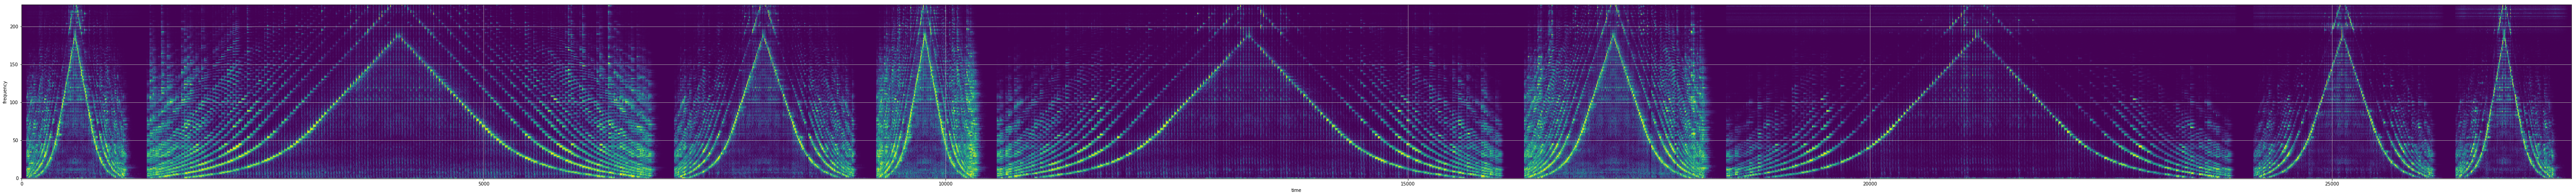

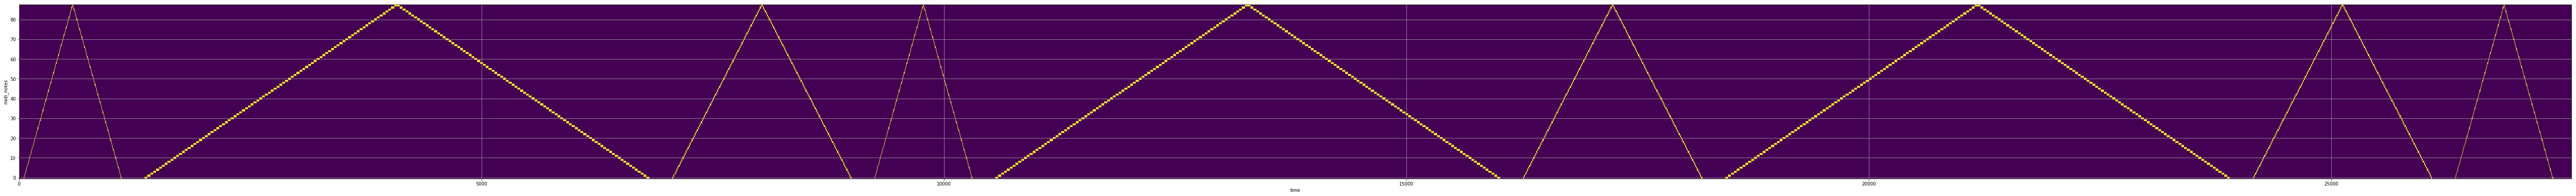

In [16]:
fig = plt.figure(figsize=(100,7))
plt.grid()
plt.imshow(spects.T ,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('frequency')
plt.show()
# fig = plt.figure(figsize=(100,7))
# plt.grid()
# plt.imshow(onsets.T ,aspect='auto')
# plt.gca().invert_yaxis()
# fig.axes[0].set_xlabel('time')
# fig.axes[0].set_ylabel('midi_notes')
# plt.show()
fig = plt.figure(figsize=(100,7))
plt.grid()
plt.imshow(froms.T ,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('midi_notes')
plt.show()

#### Save and Load

In [18]:
save_mm(INPUT_NAME, spects)
save_mm(EXPECT_NAME, froms)
loaded_spects, loaded_expects = load_mm()

In [19]:
print loaded_spects.shape
print loaded_expects.shape

(27594, 229)
(27594, 88)


In [20]:
print spects.dtype
print loaded_spects.dtype
print spects.nbytes
print loaded_spects.nbytes

float32
float32
25276104
25276104


#### After

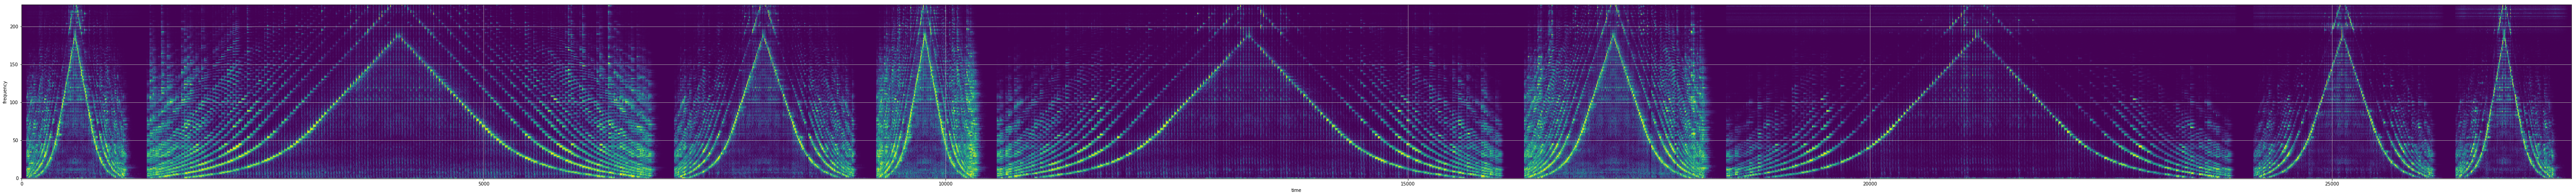

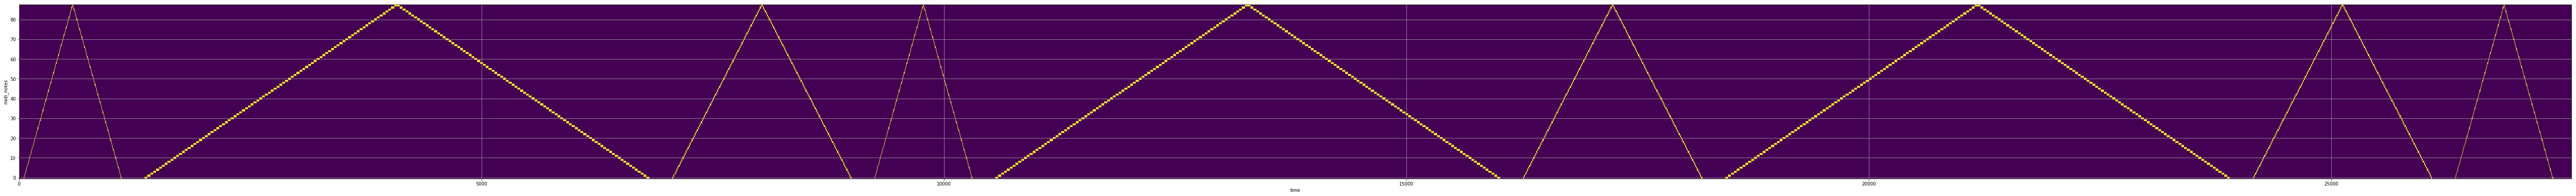

In [21]:
fig = plt.figure(figsize=(100,7))
plt.grid()
plt.imshow(loaded_spects.T,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('frequency')
plt.show()
fig = plt.figure(figsize=(100,7))
plt.grid()
plt.imshow(loaded_expects.T ,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('midi_notes')
plt.show()

## Try librosa melspec

#### Double-check with pipeline code